# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data_set(path= './data', file= 'flights.csv', test=False):
    '''
    Load Train or Test data add new features from database. 

    Parameters
    ----------
    Path : str, Location of source file. Ex. './data'.
    
    file : str, Name of file, include extension .
        Target vector relative to X.
    
    test: boolean, default=False
        True loads test. False loads train data.
           
    Returns
    -------
    X : pandas DataFrame
        DataFrame containing training or test data. 
    
    y : pandas Series (Only for training data)
        If test = False it returns a target variable in pandas Series.
    '''
    # Load Train or Test csv
    X = pd.read_csv(f'{path}/{file}')
    if test:
        return X
    else:
    # Take target variable out of flights data set
        y = X['arr_delay']
        X = X.drop('arr_delay', axis=1)
        return X, y

In [3]:
def load_agg_data(X, path= './data', test=False):
    '''
    Add aggregated variables as new features to Train or Test data set. 

    Parameters
    ----------
    X : pandas DataFrame
        Test or Train dataset.
    
    Path : str, Location of source file. Ex. './data'.
        Location of files to read and load.

    
    test: boolean, default=False
        True loads test. False loads train data.
           
    Returns
    -------
    X : pandas DataFrame
        Pandas DataFrame containing Train or Test data and additional features. 

    '''

    # Load flights aggregate data
    flight_delay_aggregate_mth = pd.read_csv('./data/flight_delay_aggregate_monthly.csv')
    flight_delay_aggregate_dow = pd.read_csv('./data/flight_delay_aggregate_day_of_week.csv')
    flight_delay_aggregate_arrive_hour= pd.read_csv('./data/flight_delay_aggregate_arrive_hour.csv')
    flight_airport_traffic = pd.read_csv('./data/flight_airport_traffic.csv')

    # Load passengers aggregate data
    passengers_flight_montly_aggregate = pd.read_csv('./data/passengers_flight_montly_aggregate.csv')
    passengers_carrier_monthly_aggregate = pd.read_csv('./data/passengers_carrier_monthly_aggregate.csv')
    passengers_airport_monthly_aggregate= pd.read_csv('./data/passengers_airport_monthly_aggregate.csv')
    # Load fuel comsumption data
    fuel_comsumption_monthyl_aggregate= pd.read_csv('./data/fuel_comsumption_monthyl_aggregate.csv')

    # join tables data from origin
    flights = pd.merge(X, flight_delay_aggregate_mth, how='left', on=['mkt_unique_carrier', 'origin_airport_id', 'dest_airport_id',  'month'])
    flights = pd.merge(flights, flight_delay_aggregate_dow, how='left', on=['mkt_unique_carrier', 'origin_airport_id', 'dest_airport_id',  'day_of_week'])
    flights = pd.merge(flights, flight_delay_aggregate_arrive_hour, how='left', on=['mkt_unique_carrier', 'origin_airport_id', 'dest_airport_id', 'crs_arr_hour'])

    # Join Airport traffic
    orig = flight_airport_traffic[['airport_id','month', 'total_flights']]
    orig.columns = ['origin_airport_id','month','origin_total_flights']
    dest = flight_airport_traffic[['airport_id','month','total_flights']]
    dest.columns = ['dest_airport_id','month','dest_total_flights']
    flights = pd.merge(flights, orig, how='left', on=['origin_airport_id','month'])
    flights = pd.merge(flights, dest, how='left', on=['dest_airport_id','month'])

    
    # Join Passengers data
    flights = pd.merge(flights, passengers_flight_montly_aggregate, how='left', on=['mkt_unique_carrier', 'origin_airport_id', 'dest_airport_id','month'])
    flights = pd.merge(flights, passengers_carrier_monthly_aggregate, how='left', on=['mkt_unique_carrier', 'month'])
    flights = pd.merge(flights, fuel_comsumption_monthyl_aggregate, how='left', on=['mkt_unique_carrier', 'month'])
    #Flights has origin and destination ariports. we add it from the table.
    orig_pass = passengers_airport_monthly_aggregate[['airport_id','month', 'airport_month_flight_seats', 'airport_month_passengers']]
    orig_pass.columns = ['origin_airport_id','month', 'orig_airport_month_flight_seats', 'orig_airport_month_passengers']
    dest_pass = passengers_airport_monthly_aggregate[['airport_id','month', 'airport_month_flight_seats', 'airport_month_passengers']]
    dest_pass.columns = ['dest_airport_id','month', 'dest_airport_month_flight_seats', 'dest_airport_month_passengers']
    flights = pd.merge(flights, orig_pass, how='left', on=['origin_airport_id','month'])
    flights = pd.merge(flights, dest_pass, how='left', on=['dest_airport_id','month'])
    
    return flights

In [4]:
# Load data
X, y = load_data_set()

In [5]:
pd.set_option("display.max_columns", None)
X.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,year,month,day,day_of_week,week_of_year,crs_dep_hour,crs_arr_hour
0,2018-10-30,UA,UA_CODESHARE,UA,3997,EV,N13903,3997,12266,IAH,"Houston, TX",13256,MFE,"Mission/McAllen/Edinburg, TX",1455,1617,N,82,1,316,2018,10,30,2,44,14,16
1,2018-10-30,F9,F9,F9,529,F9,N301FR,529,10599,BHM,"Birmingham, AL",11292,DEN,"Denver, CO",1315,1518,N,183,1,1083,2018,10,30,2,44,13,15
2,2018-10-30,AA,AA,AA,2318,AA,N167AN,2318,11298,DFW,"Dallas/Fort Worth, TX",12892,LAX,"Los Angeles, CA",1740,1853,N,193,1,1235,2018,10,30,2,44,17,18
3,2018-10-30,AA,AA,AA,2375,AA,N962NN,2375,11298,DFW,"Dallas/Fort Worth, TX",14869,SLC,"Salt Lake City, UT",1855,2048,N,173,1,989,2018,10,30,2,44,18,20
4,2018-10-31,UA,UA,UA,746,UA,N68836,746,12173,HNL,"Honolulu, HI",14771,SFO,"San Francisco, CA",1433,2236,N,303,1,2398,2018,10,31,3,44,14,22


In [6]:
to_drop = ['mkt_carrier', 'tail_num', 'origin_city_name', 'dest_city_name', 'dup', 'fl_date', 'branded_code_share', 'op_unique_carrier']
train = X.drop(to_drop, axis=1)

In [7]:
to_drop = ['origin', 'dest']
train = train.drop(to_drop, axis=1)

In [8]:
train = load_agg_data(train)

In [9]:
train.shape

(9808, 53)

In [10]:
# Save data in local disk
train.to_csv('./data/train.csv', index=False)
y.to_csv('./data/target.csv', index=False)

In [11]:
train.dtypes

mkt_unique_carrier                      object
mkt_carrier_fl_num                       int64
op_carrier_fl_num                        int64
origin_airport_id                        int64
dest_airport_id                          int64
crs_dep_time                             int64
crs_arr_time                             int64
crs_elapsed_time                         int64
flights                                  int64
distance                                 int64
year                                     int64
month                                    int64
day                                      int64
day_of_week                              int64
week_of_year                             int64
crs_dep_hour                             int64
crs_arr_hour                             int64
month_avg_arr_delay                    float64
month_avg_air_time                     float64
month_avg_carrier_delay                float64
month_avg_weather_delay                float64
month_avg_nas

In [12]:
sorted(list(train.columns))

['arr_hour_avg_air_time',
 'arr_hour_avg_arr_delay',
 'arr_hour_avg_carrier_delay',
 'arr_hour_avg_late_aircraft_delay',
 'arr_hour_avg_nas_delay',
 'arr_hour_avg_security_delay',
 'arr_hour_avg_weather_delay',
 'carrier_month_avg_passengers',
 'carrier_month_avg_seats',
 'carrier_month_passengers',
 'carrier_month_seats',
 'crs_arr_hour',
 'crs_arr_time',
 'crs_dep_hour',
 'crs_dep_time',
 'crs_elapsed_time',
 'day',
 'day_of_week',
 'day_of_week_avg_air_time',
 'day_of_week_avg_arr_delay',
 'day_of_week_avg_carrier_delay',
 'day_of_week_avg_late_aircraft_delay',
 'day_of_week_avg_nas_delay',
 'day_of_week_avg_security_delay',
 'day_of_week_avg_weather_delay',
 'dest_airport_id',
 'dest_airport_month_flight_seats',
 'dest_airport_month_passengers',
 'dest_total_flights',
 'distance',
 'flights',
 'mkt_carrier_fl_num',
 'mkt_unique_carrier',
 'month',
 'month_avg_air_time',
 'month_avg_arr_delay',
 'month_avg_carrier_delay',
 'month_avg_fuel_comsumption',
 'month_avg_late_aircraft_dela

In [13]:
def print_null_features(df):
    # missing data
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    print("Missing data:")
    print(missing_data.head(30))
    
    return total


def num_null_replacement(df):  
    '''
    Replaces null values to all numeric features in Train or Test data set. 

    Parameters
    ----------
    X : pandas DataFrame
        Test or Train dataset.
    
    Path : str, Location of source file. Ex. './data'.
        Location of files to read and load.

    
    test: boolean, default=False
        True loads test. False loads train data.
           
    Returns
    -------
    X : pandas DataFrame
        Pandas DataFrame containing Train or Test data and additional features. 

    '''
    
    # Print missing data
    total = print_null_features(df)
    
    for feature in total[total > 0].index:
        if df[feature].dtypes != 'object':
            df[feature] = df[feature].fillna(0)
            
    print_null_features(df)
    
    return df

In [14]:
train = num_null_replacement(train)

Missing data:
                                     Total   Percent
month_flight_avg_passengers           1915  0.195249
month_flight_seats                    1915  0.195249
month_flight_passengers               1915  0.195249
month_flight_avg_seats                1915  0.195249
arr_hour_avg_weather_delay              29  0.002957
arr_hour_avg_security_delay             29  0.002957
arr_hour_avg_late_aircraft_delay        29  0.002957
arr_hour_avg_nas_delay                  29  0.002957
arr_hour_avg_carrier_delay              29  0.002957
month_avg_late_aircraft_delay           22  0.002243
month_avg_security_delay                22  0.002243
month_avg_nas_delay                     22  0.002243
month_avg_weather_delay                 22  0.002243
month_avg_carrier_delay                 22  0.002243
day_of_week_avg_nas_delay                5  0.000510
day_of_week_avg_weather_delay            5  0.000510
day_of_week_avg_security_delay           5  0.000510
day_of_week_avg_late_aircraft_de

In [30]:
total[total > 0].index

Index(['month_flight_avg_passengers', 'month_flight_avg_seats',
       'month_flight_passengers', 'month_flight_seats', 'tail_num',
       'arr_hour_avg_late_aircraft_delay', 'arr_hour_avg_carrier_delay',
       'arr_hour_avg_weather_delay', 'arr_hour_avg_nas_delay',
       'arr_hour_avg_security_delay', 'month_avg_nas_delay',
       'month_avg_late_aircraft_delay', 'month_avg_security_delay',
       'month_avg_weather_delay', 'month_avg_carrier_delay',
       'day_of_week_avg_late_aircraft_delay', 'day_of_week_avg_security_delay',
       'day_of_week_avg_nas_delay', 'day_of_week_avg_weather_delay',
       'day_of_week_avg_carrier_delay'],
      dtype='object')

In [36]:
# missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

,Total,Percent
dest_airport_month_passengers,0,0.0
day_of_week_avg_air_time,0,0.0
month_avg_late_aircraft_delay,0,0.0
month_avg_security_delay,0,0.0
month_avg_nas_delay,0,0.0
month_avg_weather_delay,0,0.0
month_avg_carrier_delay,0,0.0
month_avg_air_time,0,0.0
month_avg_arr_delay,0,0.0
crs_arr_hour,0,0.0


In [ ]:
'month_flight_avg_passengers'
'month_flight_avg_seats'
'month_flight_passengers'
'month_flight_seats'
'tail_num'
'arr_hour_avg_late_aircraft_delay'
'arr_hour_avg_carrier_delay'
'arr_hour_avg_weather_delay'
'arr_hour_avg_nas_delay'
'arr_hour_avg_security_delay'
'month_avg_nas_delay'
'month_avg_late_aircraft_delay'
'month_avg_security_delay'
'month_avg_weather_delay'
'month_avg_carrier_delay'
'day_of_week_avg_late_aircraft_delay'
'day_of_week_avg_security_delay'
'day_of_week_avg_nas_delay'
'day_of_week_avg_weather_delay'
'day_of_week_avg_carrier_delay'

In [13]:
train['month_flight_avg_passengers'] = train['month_flight_avg_passengers'].fillna(0)
train['month_flight_avg_seats'] = train['month_flight_avg_seats'].fillna(0)
train['month_flight_passengers'] = train['month_flight_passengers'].fillna(0)
train['month_flight_seats'] = train['month_flight_seats'].fillna(0)
train['tail_num'] = train['tail_num'].fillna('Empty')
train['arr_hour_avg_late_aircraft_delay'] = train['arr_hour_avg_late_aircraft_delay'].fillna(0)
train['arr_hour_avg_carrier_delay'] = train['arr_hour_avg_carrier_delay'].fillna(0)
train['arr_hour_avg_weather_delay'] = train['arr_hour_avg_weather_delay'].fillna(0)
train['arr_hour_avg_nas_delay'] = train['arr_hour_avg_nas_delay'].fillna(0)
train['arr_hour_avg_security_delay'] = train['arr_hour_avg_security_delay'].fillna(0)
train['month_avg_nas_delay'] = train['month_avg_nas_delay'].fillna(0)
train['month_avg_late_aircraft_delay'] = train['month_avg_late_aircraft_delay'].fillna(0)
train['month_avg_security_delay'] = train['month_avg_security_delay'].fillna(0)
train['month_avg_weather_delay'] = train['month_avg_weather_delay'].fillna(0)
train['month_avg_carrier_delay'] = train['month_avg_carrier_delay'].fillna(0)
train['day_of_week_avg_late_aircraft_delay'] = train['day_of_week_avg_late_aircraft_delay'].fillna(0)
train['day_of_week_avg_security_delay'] = train['day_of_week_avg_security_delay'].fillna(0)
train['day_of_week_avg_nas_delay'] = train['day_of_week_avg_nas_delay'].fillna(0)
train['day_of_week_avg_weather_delay'] = train['day_of_week_avg_weather_delay'].fillna(0)
train['day_of_week_avg_carrier_delay'] = train['day_of_week_avg_carrier_delay'].fillna(0)

In [16]:
# missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

,Total,Percent
dest_airport_month_passengers,0,0.0
month,0,0.0
month_avg_security_delay,0,0.0
month_avg_nas_delay,0,0.0
month_avg_weather_delay,0,0.0
month_avg_carrier_delay,0,0.0
month_avg_air_time,0,0.0
month_avg_arr_delay,0,0.0
crs_arr_hour,0,0.0
crs_dep_hour,0,0.0


In [37]:
pd.set_option('display.max_columns', None)
train.describe()

,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,year,month,day,day_of_week,week_of_year,crs_dep_hour,crs_arr_hour,month_avg_arr_delay,month_avg_air_time,month_avg_carrier_delay,month_avg_weather_delay,month_avg_nas_delay,month_avg_security_delay,month_avg_late_aircraft_delay,day_of_week_avg_arr_delay,day_of_week_avg_air_time,day_of_week_avg_carrier_delay,day_of_week_avg_weather_delay,day_of_week_avg_nas_delay,day_of_week_avg_security_delay,day_of_week_avg_late_aircraft_delay,arr_hour_avg_arr_delay,arr_hour_avg_air_time,arr_hour_avg_carrier_delay,arr_hour_avg_weather_delay,arr_hour_avg_nas_delay,arr_hour_avg_security_delay,arr_hour_avg_late_aircraft_delay,origin_total_flights,dest_total_flights,month_flight_seats,month_flight_passengers,month_flight_avg_seats,month_flight_avg_passengers,carrier_month_seats,carrier_month_passengers,carrier_month_avg_seats,carrier_month_avg_passengers,month_avg_fuel_comsumption,orig_airport_month_flight_seats,orig_airport_month_passengers,dest_airport_month_flight_seats,dest_airport_month_passengers
count,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.0,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9808.000000,9.808000e+03,9.808000e+03,9808.000000,9808.000000,9.808000e+03,9.808000e+03,9.808000e+03,9.808000e+03,9.808000e+03
mean,2707.498675,2707.801387,12662.845534,12672.059849,1321.350428,1484.140498,137.231342,1.0,763.586970,2018.509380,6.594413,15.732463,2.954731,26.759278,12.941272,14.549857,5.377172,107.085865,20.704950,3.572494,14.775467,0.096572,26.381614,5.442743,107.097324,20.695272,3.734985,15.149646,0.095616,26.766619,5.428271,107.148964,22.711184,3.930713,15.156821,0.112191,24.198421,48047.722777,48326.727467,74821.445657,62345.875102,123.791124,98.359309,6.098729e+07,5.084760e+07,160.914975,129.630580,1.423486e+08,1.698409e+07,1.413582e+07,1.711731e+07,1.424720e+07
std,1866.075408,1867.024817,1529.959986,1517.766954,488.252435,510.015498,71.829131,0.0,590.063298,0.499937,3.368539,8.734986,1.954512,14.690827,4.866948,5.098056,8.992601,69.256529,16.536024,8.180063,12.845552,0.943060,15.315799,7.329838,69.168151,13.443006,5.602439,11.364261,0.518155,12.551233,10.055264,69.227509,19.036367,8.954399,12.042137,0.834361,16.735571,39096.022589,38955.185150,90536.406764,76567.629037,64.624674,55.135198,2.319995e+07,1.950508e+07,13.600378,12.716215,5.018169e+07,1.411573e+07,1.198523e+07,1.406297e+07,1.193149e+07
min,1.000000,1.000000,10135.000000,10135.000000,5.000000,1.000000,25.000000,1.0,31.000000,2018.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-38.076923,11.763636,0.000000,0.000000,0.000000,0.000000,0.000000,-29.833333,11.840000,0.000000,0.000000,0.000000,0.000000,0.000000,-30.000000,11.864407,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,124.000000,0.000000,0.000000,0.000000,0.000000,2.815632e+06,2.186289e+06,138.923903,103.652188,1.051973e+07,5.700000e+03,3.171000e+03,1.024200e+04,5.979000e+03
25%,1104.000000,1104.000000,11292.000000,11292.000000,907.000000,1059.000000,86.000000,1.0,337.000000,2018.000000,4.000000,8.000000,1.000000,14.000000,9.000000,10.000000,-0.515419,57.302888,11.500000,0.000000,6.848914,0.000000,16.784761,0.655416,57.208919,12.830166,0.403846,7.941176,0.000000,18.720541,-1.626220,57.360215,11.587958,0.090738,7.427679,0.000000,12.276583,15547.500000,16789.000000,1660.500000,1100.250000,120.791773,79.743593,5.300181e+07,4.450600e+07,153.179572,121.712685,1.327597e+08,4.419152e+06,3.558073e+06,4.734830e+06,3.763481e+06
50%,2266.000000,2266.000000,12889.000000,12889.

<AxesSubplot:xlabel='month_avg_late_aircraft_delay', ylabel='arr_delay'>

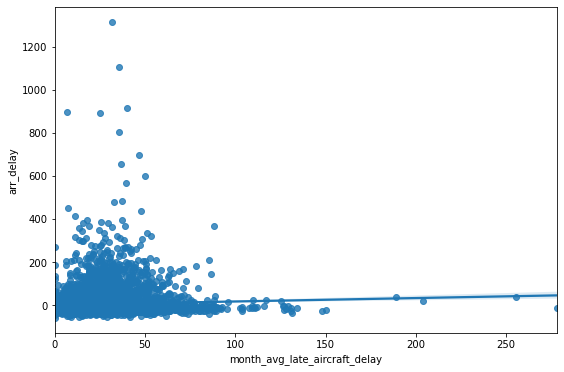

In [18]:

f, ax = plt.subplots(figsize=(9, 6))
# seaborn's regression plot
sns.regplot(x=(train['month_avg_late_aircraft_delay']), y=y, data=train, order=1)

<AxesSubplot:xlabel='month_avg_late_aircraft_delay', ylabel='month_flight_passengers'>

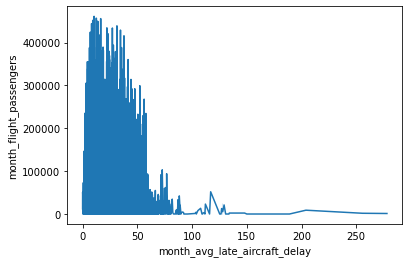

In [63]:
sns.lineplot(data=train, x="month_avg_late_aircraft_delay", y="month_flight_passengers")

In [21]:
train.dtypes[train.dtypes == 'object']

mkt_unique_carrier    object
dtype: object

In [ ]:

# fl_date numeric
#train['fl_date'] = train['fl_date'].replace('-', '', regex=True).astype(int)
# mkt_unique_carrier - hot-encode



# drop fl_date

In [22]:
def one_hot_encode(X):
    cat_feats = train.dtypes[X.dtypes == 'object'].index.tolist()
    df_dummy = pd.get_dummies(X[cat_feats])
    return df_dummy

def label_encode():
    pass



def print_cat_describe(df):
    for col in train.dtypes[train.dtypes == 'object'].index:
        print("Variable: ", col)
        print(df[col].describe())
        print("Unique values: ", df[col].unique())
        print('')

def scale_data(X):
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X.astype(float)))
    return X_scaled

In [18]:
train['fl_date'] = date_numeric(train['fl_date'])

In [23]:
train.dtypes[train.dtypes == 'object']

mkt_unique_carrier    object
dtype: object

In [20]:
#drop
# mkt_carrier
# tail_num - do we need it?
# origin
# origin_city_name
# dest
# dest_city_name
# dup - it contains only N - we do not need it
#to_drop = ['mkt_carrier', 'tail_num', 'origin', 'origin_city_name', 'dest', 'dest_city_name', 'dup', 'fl_date']
to_drop = ['mkt_carrier', 'tail_num', 'origin_city_name', 'dest_city_name', 'dup', 'fl_date', 'branded_code_share', 'op_unique_carrier']
train = train.drop(to_drop, axis=1)

In [24]:
train.dtypes[train.dtypes == 'object']

mkt_unique_carrier    object
dtype: object

In [25]:
print_cat_describe(train)

Variable:  mkt_unique_carrier
count     9808
unique      11
top         AA
freq      2516
Name: mkt_unique_carrier, dtype: object
Unique values:  ['UA' 'F9' 'AA' 'AS' 'WN' 'DL' 'B6' 'NK' 'HA' 'G4' 'VX']



In [26]:
df_dummy = one_hot_encode(train)

In [27]:
df_dummy

,mkt_unique_carrier_AA,mkt_unique_carrier_AS,mkt_unique_carrier_B6,mkt_unique_carrier_DL,mkt_unique_carrier_F9,mkt_unique_carrier_G4,mkt_unique_carrier_HA,mkt_unique_carrier_NK,mkt_unique_carrier_UA,mkt_unique_carrier_VX,mkt_unique_carrier_WN
0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9803,1,0,0,0,0,0,0,0,0,0,0
9804,1,0,0,0,0,0,0,0,0,0,0
9805,0,0,0,1,0,0,0,0,0,0,0
9806,0,0,0,1,0,0,0,0,0,0,0


In [34]:
train.head()

,mkt_unique_carrier,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,year,month,day,day_of_week,week_of_year,crs_dep_hour,crs_arr_hour,month_avg_arr_delay,month_avg_air_time,month_avg_carrier_delay,month_avg_weather_delay,month_avg_nas_delay,month_avg_security_delay,month_avg_late_aircraft_delay,day_of_week_avg_arr_delay,day_of_week_avg_air_time,day_of_week_avg_carrier_delay,day_of_week_avg_weather_delay,day_of_week_avg_nas_delay,day_of_week_avg_security_delay,day_of_week_avg_late_aircraft_delay,arr_hour_avg_arr_delay,arr_hour_avg_air_time,arr_hour_avg_carrier_delay,arr_hour_avg_weather_delay,arr_hour_avg_nas_delay,arr_hour_avg_security_delay,arr_hour_avg_late_aircraft_delay,origin_total_flights,dest_total_flights,month_flight_seats,month_flight_passengers,month_flight_avg_seats,month_flight_avg_passengers,carrier_month_seats,carrier_month_passengers,carrier_month_avg_seats,carrier_month_avg_passengers,month_avg_fuel_comsumption,orig_airport_month_flight_seats,orig_airport_month_passengers,dest_airport_month_flight_seats,dest_airport_month_passengers
0,UA,3997,3997,12266,13256,1455,1617,82,1,316,2018,10,30,2,44,14,16,9.749340,53.232190,36.952381,4.238095,13.892857,0.0,10.690476,8.732231,53.522314,18.540323,12.298387,10.580645,0.0,28.370968,6.329897,53.782032,23.574468,7.212766,8.751773,0.0,23.503546,60613,1764,46933.0,27677.0,150.426277,82.035018,55003329,45704398,169.542505,134.985112,1.378381e+08,21173178,17176426,405577,288439
1,F9,529,529,10599,11292,1315,1518,183,1,1083,2018,10,30,2,44,13,15,9.230769,154.653846,9.200000,0.000000,14.500000,0.0,13.600000,6.806452,152.129032,8.300000,1.400000,18.100000,0.0,13.200000,10.578947,153.894737,12.625000,0.000000,10.000000,0.0,15.625000,7183,97485,4728.0,4203.0,176.600000,159.452381,9175856,7825867,182.916216,150.583777,1.878024e+07,1624146,1304863,30526301,26412747
2,AA,2318,2318,11298,12892,1740,1853,193,1,1235,2018,10,30,2,44,17,18,12.060780,167.094037,21.235808,11.449782,8.200873,0.0,23.078603,2.587422,167.238424,22.679245,4.456604,9.173585,0.0,23.649057,13.709353,168.212950,25.615000,5.910000,8.015000,0.0,22.035000,100056,83560,414528.0,376739.0,215.590837,192.751409,74614837,62505008,168.496511,136.733012,1.819297e+08,33551297,27909683,41526408,34347751
3,AA,2375,2375,11298,14869,1855,2048,173,1,989,2018,10,30,2,44,18,20,15.659942,138.567723,14.092784,8.505155,7.144330,0.0,34.474227,9.633648,139.055031,25.697368,4.361842,5.651316,0.0,20.118421,22.419118,138.664216,16.912281,6.333333,6.853801,0.0,25.140351,100056,40380,128478.0,107398.0,157.619886,128.523313,74614837,62505008,168.496511,136.733012,1.819297e+08,33551297,27909683,11730371,9839898
4,UA,746,746,12173,14771,1433,2236,303,1,2398,2018,10,31,3,44,14,22,0.732704,274.103774,13.916667,0.416667,11.416667,0.0,26.527778,3.350202,269.595142,22.764706,0.000000,7.558824,0.0,40.500000,3.611321,274.694340,9.094340,0.000000,10.377358,0.0,28.132075,18549,59900,195967.0,160718.0,241.446000,194.466981,55003329,45704398,169.542505,134.985112,1.378381e+08,9959578,8131626,28213693,22922751


In [28]:
train_cleaned = pd.merge(train, df_dummy, left_index=True, right_index=True)

In [29]:
train_cleaned.shape

(9808, 64)

In [30]:
train_cleaned.dtypes[train_cleaned.dtypes == 'object']

mkt_unique_carrier    object
dtype: object

In [12]:
to_drop = ['mkt_unique_carrier', 'branded_code_share', 'op_unique_carrier']
train_cleaned = train_cleaned.drop(to_drop, axis=1)

NameError: name 'train_cleaned' is not defined

In [31]:
train_cleaned.dtypes[train_cleaned.dtypes == 'object']

Series([], dtype: object)

In [31]:
train_cleaned.shape

(9808, 64)

In [32]:
train_cleaned.to_csv('./data/train_cleaned.csv', index=False)

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [33]:
train_cleaned


,mkt_unique_carrier,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,year,month,day,day_of_week,week_of_year,crs_dep_hour,crs_arr_hour,month_avg_arr_delay,month_avg_air_time,month_avg_carrier_delay,month_avg_weather_delay,month_avg_nas_delay,month_avg_security_delay,month_avg_late_aircraft_delay,day_of_week_avg_arr_delay,day_of_week_avg_air_time,day_of_week_avg_carrier_delay,day_of_week_avg_weather_delay,day_of_week_avg_nas_delay,day_of_week_avg_security_delay,day_of_week_avg_late_aircraft_delay,arr_hour_avg_arr_delay,arr_hour_avg_air_time,arr_hour_avg_carrier_delay,arr_hour_avg_weather_delay,arr_hour_avg_nas_delay,arr_hour_avg_security_delay,arr_hour_avg_late_aircraft_delay,origin_total_flights,dest_total_flights,month_flight_seats,month_flight_passengers,month_flight_avg_seats,month_flight_avg_passengers,carrier_month_seats,carrier_month_passengers,carrier_month_avg_seats,carrier_month_avg_passengers,month_avg_fuel_comsumption,orig_airport_month_flight_seats,orig_airport_month_passengers,dest_airport_month_flight_seats,dest_airport_month_passengers,mkt_unique_carrier_AA,mkt_unique_carrier_AS,mkt_unique_carrier_B6,mkt_unique_carrier_DL,mkt_unique_carrier_F9,mkt_unique_carrier_G4,mkt_unique_carrier_HA,mkt_unique_carrier_NK,mkt_unique_carrier_UA,mkt_unique_carrier_VX,mkt_unique_carrier_WN
0,UA,3997,3997,12266,13256,1455,1617,82,1,316,2018,10,30,2,44,14,16,9.749340,53.232190,36.952381,4.238095,13.892857,0.000000,10.690476,8.732231,53.522314,18.540323,12.298387,10.580645,0.0,28.370968,6.329897,53.782032,23.574468,7.212766,8.751773,0.0,23.503546,60613,1764,46933.0,27677.0,150.426277,82.035018,55003329,45704398,169.542505,134.985112,1.378381e+08,21173178,17176426,405577,288439,0,0,0,0,0,0,0,0,1,0,0
1,F9,529,529,10599,11292,1315,1518,183,1,1083,2018,10,30,2,44,13,15,9.230769,154.653846,9.200000,0.000000,14.500000,0.000000,13.600000,6.806452,152.129032,8.300000,1.400000,18.100000,0.0,13.200000,10.578947,153.894737,12.625000,0.000000,10.000000,0.0,15.625000,7183,97485,4728.0,4203.0,176.600000,159.452381,9175856,7825867,182.916216,150.583777,1.878024e+07,1624146,1304863,30526301,26412747,0,0,0,0,1,0,0,0,0,0,0
2,AA,2318,2318,11298,12892,1740,1853,193,1,1235,2018,10,30,2,44,17,18,12.060780,167.094037,21.235808,11.449782,8.200873,0.000000,23.078603,2.587422,167.238424,22.679245,4.456604,9.173585,0.0,23.649057,13.709353,168.212950,25.615000,5.910000,8.015000,0.0,22.035000,100056,83560,414528.0,376739.0,215.590837,192.751409,74614837,62505008,168.496511,136.733012,1.819297e+08,33551297,27909683,41526408,34347751,1,0,0,0,0,0,0,0,0,0,0
3,AA,2375,2375,11298,14869,1855,2048,173,1,989,2018,10,30,2,44,18,20,15.659942,138.567723,14.092784,8.505155,7.144330,0.000000,34.474227,9.633648,139.055031,25.697368,4.361842,5.651316,0.0,20.118421,22.419118,138.664216,16.912281,6.333333,6.853801,0.0,25.140351,100056,40380,128478.0,107398.0,157.619886,128.523313,74614837,62505008,168.496511,136.733012,1.819297e+08,33551297,27909683,11730371,9839898,1,0,0,0,0,0,0,0,0,0,0
4,UA,746,746,12173,14771,1433,2236,303,1,2398,2018,10,31,3,44,14,22,0.732704,274.103774,13.916667,0.416667,11.416667,0.000000,26.527778,3.350202,269.595142,22.764706,0.000000,7.558824,0.0,40.500000,3.611321,274.694340,9.094340,0.000000,10.377358,0.0,28.132075,18549,59900,195967.0,160718.0,241.446000,194.466981,55003329,45704398,169.542505,134.985112,1.378381e+08,9959578,8131626,28213693,22922751,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9803,AA,5510,5510,13931,11278,1718,1820,62,1,142,2018,10,30,2,44,17,18,7.348571,36.297143,26.394737,0.210526,15.947368,0.000000,25.605263,17.087379,36.475728,39.608108,0.256757,21.783784,0.0,36.635135,21.597403,37.049784,9.093525,4.741007,26.3021

In [37]:
scale_data(train_cleaned)

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,-0.945485,0.691058,0.690545,-0.259396,0.384756,0.273744,0.260514,-0.768966,0.0,-0.758579,...,-0.199660,-0.332237,-0.113619,-0.130808,-0.305651,-0.035,-0.450547,-0.16338,-0.212564,-0.115899
1,-0.945485,-1.167482,-1.167051,-1.349023,-0.909316,-0.013007,0.066393,0.637220,0.0,0.541348,...,-0.199660,-0.332237,-0.113619,-0.130808,-0.305651,-0.035,-0.450547,-0.16338,-0.212564,-0.115899
2,-0.945485,-0.208737,-0.208793,-0.892125,0.144918,0.857489,0.723269,0.776447,0.0,0.798960,...,-0.199660,-0.332237,-0.113619,-0.130808,-0.305651,-0.035,-0.450547,-0.16338,-0.212564,-0.115899
3,-0.945485,-0.178190,-0.178261,-0.892125,1.447556,1.093035,1.105630,0.497994,0.0,0.382034,...,-0.199660,-0.332237,-0.113619,-0.130808,-0.305651,-0.035,-0.450547,-0.16338,-0.212564,-0.115899
4,-0.945286,-1.051189,-1.050817,-0.320185,1.382984,0.228683,1.474265,2.307937,0.0,2.770036,...,-0.199660,-0.332237,-0.113619,-0.130808,3.271706,-0.035,-0.450547,-0.16338,-0.212564,-0.115899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9803,-0.945485,1.501892,1.500966,0.828923,-0.918541,0.812428,0.658562,-1.047419,0.0,-1.053478,...,5.008503,-0.332237,-0.113619,-0.130808,-0.305651,-0.035,-0.450547,-0.16338,-0.212564,-0.115899
9804,-0.945485,1.163196,1.162443,0.939389,1.220236,0.990623,0.874252,-0.727198,0.0,-0.958568,...,-0.199660,-0.332237,8.801364,-0.130808,-0.305651,-0.035,-0.450547,-0.16338,-0.212564,-0.115899
9805,-0.945485,-1.217858,-1.217401,-0.120823,1.367170,-0.432893,-0.112042,3.338212,0.0,2.810711,...,-0.199660,-0.332237,-0.113619,-0.130808,-0.305651,-0.035,-0.450547,-0.16338,-0.212564,-0.115899
9806,-0.945485,-0.646576,-0.646410,-1.269278,-1.499028,-1.037120,-0.843430,0.303077,0.0,0.309157,...,-0.199660,-0.332237,-0.113619,-0.130808,-0.305651,-0.035,-0.450547,-0.16338,-0.212564,-0.115899


In [38]:
train_cleaned.to_csv('./data/train_cleaned.csv', index=False)

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.